<a href="https://colab.research.google.com/github/jjiho/20141001-Lee-Jiho/blob/master/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  11879      0 --:--:-- --:--:-- --:--:-- 11969
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 337.3MB 35kB/s 
+ set +ex
Installation succeeded!


In [50]:
import numpy as np
import cupy as cp
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
#################
from google.colab import drive
drive.mount('/content/gdrive')
#################
from zipfile import ZipFile
file_name = "gdrive/My Drive/movie_review.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')
##################
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Done


In [51]:
X_train = cp.array(X_train)
X_test = cp.array(X_test)
y_train = cp.array(y_train)
y_test = cp.array(y_test)

y_train = y_train.reshape((1401,1))
y_test = y_test.reshape((601,1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1401, 1500)
(601, 1500)
(1401, 1)
(601, 1)


In [52]:
theta_u = cp.random.randn(1501, 500)
theta_v = cp.random.randn(501, 50)
theta_w = cp.random.randn(51, 1)

def sigmoid_prime(s) :
  return (sigmoid(s))*(1-sigmoid(s))
  
def bias(input_layer):
    input_layer = cp.array(np.insert(cp.asnumpy(input_layer), 0, 1, axis = 1))
    return input_layer

def sigmoid(s):
    return 1 / (1+cp.exp(-(s)))

print(y_train.shape)

(1401, 1)


In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def Objective_Function(input, input_test, theta_u, theta_v, theta_w, label_train, label_test, num_of_learning = 40000, learning_rate = 0.7, lamb = 23):
  loss_train = []
  loss_test = []
  acc_train = []
  acc_testing = []

  num_thetas = 1500 * 500 + 500 * 50 + 50 * 1
  
  for i in range(num_of_learning):
    '''
    if(i % 10 == 1):
      print(loss_train[-1], loss_test[-1], acc_train[-1], acc_testing[-1])
    '''
    layer1 = cp.dot(bias(input), theta_u)
    sig_layer1 = bias(sigmoid(layer1))
    
    layer2 = cp.dot(sig_layer1, theta_v)
    sig_layer2 = bias(sigmoid(layer2))

    layer3 = cp.dot(sig_layer2, theta_w)
    sig_layer3 = sigmoid(layer3)

    layer1_t = cp.dot(bias(input_test), theta_u)
    sig_layer1_t = bias(sigmoid(layer1_t))

    layer2_t = cp.dot(sig_layer1_t, theta_v)
    sig_layer2_t = bias(sigmoid(layer2_t))

    layer3_t = cp.dot(sig_layer2_t, theta_w)
    sig_layer3_t = sigmoid(layer3_t)

    sum_theta = cp.sum(theta_u**2) + cp.sum(theta_v**2) + cp.sum(theta_w**2)

    loss_train.append(loss_function(sig_layer3, label_train, 1401, sum_theta, num_thetas, lamb))
    loss_test.append(loss_function(sig_layer3_t, label_test, 601, sum_theta, num_thetas, lamb))

    acc_train.append(get_accuracy(sig_layer3, label_train, 1401))
    acc_testing.append(get_accuracy(sig_layer3_t, label_test, 601))

    if i == num_of_learning - 1:
      answer = np.where(cp.asnumpy(sig_layer3[:,0]) >= 0.5, 1, 0)
      labeln = cp.asnumpy(label_train[:,0])
      print("done")
      c_m = confusion_matrix(labeln, answer)
      c_r = classification_report(labeln, answer)
      a_s = accuracy_score(labeln, answer)


      answer_test = np.where(cp.asnumpy(sig_layer3_t[:,0]) >= 0.5, 1, 0)
      labeln_test = cp.asnumpy(label_test[:,0])
      print("done")
      c_m_test = confusion_matrix(labeln_test, answer_test)
      c_r_test = classification_report(labeln_test, answer_test)
      a_s_test = accuracy_score(labeln_test, answer_test)

    part1 = ((1-label_train) / (1 - sig_layer3) - (label_train / sig_layer3)) * sigmoid_prime(layer3)
    
    gd_w = cp.dot(cp.transpose(part1), sig_layer2)
    part2 = cp.dot(part1, cp.transpose(theta_w[1:])) * sigmoid_prime(layer2)
    gd_v = cp.dot(cp.transpose(part2), sig_layer1)
    part3 = cp.dot(part2, cp.transpose(theta_v[1:])) *sigmoid_prime(layer1)
    gd_u = cp.dot(cp.transpose(part3), bias(input))


    theta_u = theta_u - learning_rate * (cp.transpose(gd_u) / 1401 + lamb * theta_u / num_thetas)
    theta_v = theta_v - learning_rate * (cp.transpose(gd_v) / 1401 + lamb * theta_v / num_thetas)
    theta_w = theta_w - learning_rate * (cp.transpose(gd_w) / 1401 + lamb * theta_w / num_thetas)

  return loss_train, loss_test, acc_train, acc_testing, theta_u, theta_v, theta_w, sig_layer3_t, c_m, c_r, a_s

def loss_function(h, label, num_data, sum_theta, num_thetas, lamb):
  ret = cp.zeros(num_data)
  ret = (-label * cp.log(h) - (1-label) * cp.log(1-h)) + lamb * (sum_theta) / (2 * num_thetas)
  #ret[:, i] = (-label[:, i]*cp.log(h[:, i]) - (1-label[:,i]) * cp.log(1-h[:, i])) + lamb * (sum_theta) / (2 * num_thetas)
  return cp.average(cp.sum(ret, axis=1))

def get_accuracy(h, label, num_data):
  answer = np.where(cp.asnumpy(h)>=0.5, 1, 0)
  labeln = cp.asnumpy(label)
  a_s = accuracy_score(labeln, answer)
  
  return a_s

loss_train, loss_testing, acc_train, acc_testing, t_u, t_v, t_w, h_test, c_m, c_r, a_s, c_m_test, c_r_test, a_s_test = Objective_Function(X_train, X_test, theta_u, theta_v, theta_w, y_train, y_test)

done
done


ValueError: ignored

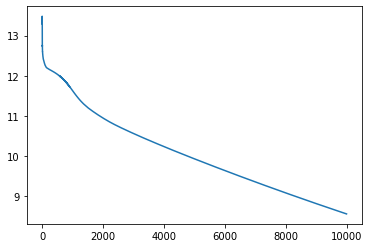

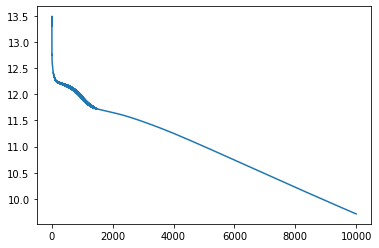

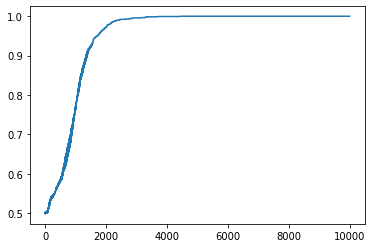

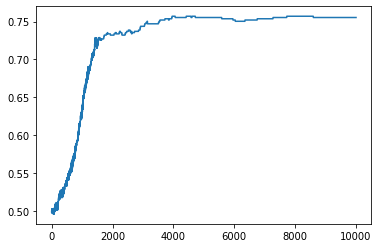

In [59]:
from matplotlib import pyplot as plt
plt.plot(loss_train, c = 'blue')
plt.plot(loss_testing, c = 'red')
plt.show()
plt.plot(acc_train, c = 'blue')
plt.plot(acc_testing, c = 'red')
plt.show()

print("Training :")
print(c_m)
print(c_r)
print(a_s)

print("\nTesting :")
print(c_m_test)
print(c_r_test)
print(a_s_test)